<a href="https://colab.research.google.com/github/LucioFassarella/COMQ/blob/main/ComQ_Problema_CorteMaximo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema do Corte Máximo:

Resolução pela estratégia QAOA

## Instalação de pacotes e métodos

In [1]:
'''
Instalação do Qiskit e pacotes de visualização
'''
!pip install qiskit -U
!pip install qiskit_aer
!pip install qiskit-ibm-runtime

import qiskit
qiskit.__version__

!pip install matplotlib
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currentl

In [2]:
'''
Pacotes e Métodos
'''

# NumPy e SciPy
import numpy as np
import scipy as sp

# Minimizador do SciPy
from scipy.optimize import minimize

# Métodos do Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit.circuit.library import QAOAAnsatz

# Estimadores do Qiskit
from qiskit_aer.primitives import Estimator # <-- Estimator para simulação clássica
# from qiskit_ibm_runtime import EstimatorV2 as Estimator # <-- Estimator para computação quântica
# from qiskit_ibm_runtime import SamplerV2 as Sampler # <-- Estimator para computação quântica

# Qiskit Runtime
#from qiskit_ibm_runtime import QiskitRuntimeService, Session

import time

## Definição de métodos específicos

In [30]:
def Hamiltoniano_Corte(num_vertices = 'int', pesos = 'list'):
    '''
    Função que contrói o Hamiltoniano de corte para um grafo.

    Entradas:
        n: número de qubits (int)
        w: matriz de pesos (list)

    Saída:
        HC: Hamiltoniano do corte (SparsePauliOp)

    Método requerido:
        from qiskit.quantum_info import SparsePauliOp

    '''

    '''
    ### Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento 'num_vertices' deve ser um inteiro positivo")
    if type(pesos) != list:
        return print("O segundo argumento 'pesos' deve ser uma lista quadrada simétrica")
    if num_vertices != len(pesos):
        return print("O comprimento da lista 'pesos' deve ser igual ao primeiro argumento 'num_vertices'")

    '''
    ### Código principal
    '''

    operadores = []

    peso_total = 0
    for j in range(num_vertices):
        for i in range(j):
            peso_total += pesos[i][j]

    operadores.append(("I",[0], peso_total/2))

    for j in range(num_vertices):
        for i in range(j):
            operadores.append(("ZZ",[i,j], -pesos[i][j]/2))

    HC = SparsePauliOp.from_sparse_list(operadores, num_qubits = num_vertices)

    return HC

In [26]:
def Operador_Separador(num_vertices = 'int', pesos = 'list', gama = 'float'):
    '''
    Função que contrói o operador separador da estratégia QAOA para um grafo.

    Entradas:
        n: número de qubits (int)
        w : matriz de pesos (list)
        g: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento deve ser um inteiro")
    if type(pesos) != list:
        return print("O segundo argumento deve ser uma lista quadrada simétrica")
    if num_vertices != len(pesos):
        return print("O comprimento da lista deve ser igual ao primeiro argumento")

    '''
    Código principal
    '''

    qc = QuantumCircuit(num_vertices, name = "H_P")

    for j in range(num_vertices):
        for i in range(j):
            qc.rzz(gama*pesos[i][j],i,j)

    return qc

In [5]:
def Operador_Misturador(num_vertices = 'int', beta = 'float'):
    '''
    Função que contrói o operador misturador da estratégia QAOA para um grafo.

    Entradas:
        num_vertices: número de qubits (int)
        beta: parâmetro real (float)

    Saída:
        qc: circuito quântico com n qubits

    Métodos requeridos:
        qiskit.QuantumCircuit

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''

    if type(num_vertices) != int:
        return print("O primeiro argumento deve ser um inteiro")

    '''
    Código principal
    '''

    qc = QuantumCircuit(num_vertices, name = "H_M")

    for i in range(num_vertices):
            qc.rx(beta,i)

    return qc

In [6]:
def QAOA_Ansatz(num_vertices = 'int', pesos = 'list', p = 'int', gama_vec = 'list', beta_vec = 'list'):
    '''
    Função que contrói o circuito quântico QAOA para um grafo.

    Entradas:
        num_vertices: número de qubits (int)
        pesos : matriz de pesos (list)
        gama_vec: lista de parâmetros reais (float)
        beta_vec: lista de parâmetros reais (float)

    Saída:
        qc: circuito quântico parametrizado com n qubits.

    Métodos requeridos:
        Hamiltoniano_Corte
        Operador_Separador
        Operador_Misturador

    '''

    '''
    Verificação da consistência dos dados de entrada
    '''
    if type(num_vertices) != int:
        return print("O primeiro argumento 'num_vertices' deve ser um inteiro.")
    if type(pesos) != list:
        return print("O segundo argumento 'pesos' deve ser uma lista quadrada simétrica.")
    if num_vertices != len(pesos):
        return print("O comprimento da lista 'pesos' deve ser igual ao primeiro argumento 'num_vertices'.")
    if type(p) != int:
        return print("O terceiro argumento 'p' deve ser um inteiro.")
    if type(gama_vec) != list:
        return print("O quarto argumento 'gama_vec' deve ser uma lista de floats.")
    if type(beta_vec) != list:
        return print("O quinto argumento 'beta_vec' deve ser uma lista de floats.")
    if len(gama_vec) != p or len(beta_vec) != p:
        return print("Os parâmetros 'gama_vec' e 'beta_vec' devem ter comprimento igual ao terceiro argumento 'p'.")

    '''
    Código principal
    '''

    # Construção do circuito
    qc = QuantumCircuit(num_vertices, name = "QAOA_Ansatz")

    for i in range(num_vertices):
        qc.h(i)

    qubits = range(num_vertices)
    for i in range(p):
        qc.append(Operador_Separador(num_vertices, pesos, gama_vec[i]), qubits)
        qc.append(Operador_Misturador(num_vertices, beta_vec[i]), qubits)

    return qc

In [7]:
def CorteQ(parametros = 'list', num_vertices = 'int', pesos = 'list', p = 'int', estimator = 'qiskit_aer.primitives'):
    '''
    Função que retorna o corte de uma partição do grafo

    Entradas:
        estimator: estimador quântico (Estimator)
        num_vertices: número de qubits (int)
        pesos: matriz de pesos (list)
        p: profundidade do ansatz QAOA (int)
        parametros: 'gama_vec + beta_vec' = lista de parâmetros combinando parâmetros de separação e  parâmetros de mistura

    Saída:
        cost = float: custo

    Métodos requeridos:
        QAOA_Ansatz
        Estimator
        pass_manager: Qiskit PassManager

    Observações:
        Para executar esta função, é necessário previamente definir o "estimator"
        e inicializar o transpilador pelo comando
        "pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)"
    '''
    # Construção do circuito QAOA
    gama_vec = list(parametros[:p])
    beta_vec = list(parametros[p:])
    QAOA = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

    # Cálculo do corte
    QAOA_transpilado = pass_manager.run(QAOA)
    HC = Hamiltoniano_Corte(num_vertices, pesos)
    HC_transpilado = HC.apply_layout(QAOA_transpilado.layout)
    job = estimator.run([(QAOA_transpilado, HC_transpilado)])
    corte = job.result()[0].data.evs

    return corte

In [20]:
'''
Funções auxiliares para pós-processamento

(Elas definem representações de inteiros em base arbitrária e vice-versa)
'''

# Função que calcula o corte máximo de um grafo
def MaxCut(num_vertices, pesos):
    '''
    Função que calcula o corte máximo de uma partição de um grafo

    Entradas:
        num_vertices (int): número de vértices do grafo
        pesos (list): matriz de pesos do grafo

    Saída:
        corte_max (float): corte máximo do grafo
        particao_max (lista): lista com a partição de corte máxima:  [Amax,Bmax]
    '''
    corte_max = 0
    for p in range(2**num_vertices):
        A = []
        B = []
        for k in range(num_vertices):
            if (p // 2**k) % 2 == 1:
                A.append(k)
            else:
                B.append(k)
        corte = Corte(pesos,A)
        if corte > corte_max:
            corte_max = corte
            particao_max = [A,B]
    return corte_max, particao_max

# Função que calcula o corte de uma partição de um grafo
def Corte(pesos,A):
    '''
    Função que calcula o corte de uma partição de um grafo

    Entradas:
        pesos: matriz de pesos (list)
        A: lista de vértices da partição

    Saída:
        corte: corte da partição (float)
    '''

    num_vertices = len(pesos)
    corte = 0
    for i in range(num_vertices):
        for j in range(i):
            if (i in A and j not in A) or (j in A and i not in A):
                corte += pesos[i][j]

    return corte

# Função que retorna o estado da base computacional mais proeminente de um estado gerado por um circuito quântico
def estado_base_max(qc, num_qubits):
    '''
    Determina o estado da base computacional que tem maior probabilidade no estado
     gerado por um circuito quântico 'qc' num registro quântico com 'num_qubits' qubits.

    Entradas:
        qc (QuantumCircuit): circuito quântico
        num_qubits (int): número de qubits do circuito

    Saída:
        string: o estado da base com maior probabilidade, na forma de string binária

    Métodos:
        qiskit.QuantumCircuit
        qiskit.quantum_info.Statevector
        numpy as np
    '''

    estado = Statevector.from_instruction(qc)
    probabilidades = estado.probabilities()
    estado_base_maximo = np.argmax(probabilidades)
    return format(estado_base_maximo, f'0{num_qubits}b')

# Função que retorna a lista de comprimento 'l' com os dígitos na base 'b' de um inteiro 'x' dado na base 10
def numero_para_digitos(numero = 'int', base = 'int', num_digitos = 'int'):
    '''
    Função que retorna a lista de dígitos do inteiro 'numero'  na base 'base'
    com comprimento 'num_digitos' (no mínimo) e na ordem anti-lexicográfica

    Entradas:
        base : inteiro positivo : base
        numero : inteiro a ser apresentado na base 'b'
        num_digitos: inteiro positivo : comprimento da representação

    Saída:
        list : lista de inteiros positivos
    '''
    if numero < 0:
        sign = -1
    else:
        sign = 1

    numero *= sign

    ordem = 0
    while numero >= base**ordem:
        ordem += 1

    ordem = max(ordem, num_digitos)

    digitos = [0 for k in range(ordem)]

    x = numero
    for k in range(ordem):
        expoente = ordem - k - 1
        digitos[k] = x // base**expoente
        x = x % base**expoente

    return np.array(digitos)

# Função que retorna o número escrito na base 10 para dada lista 'lista' com seus dígitos na base 'b'
def digitos_para_numero(digitos = 'list', base = 'int'):
    '''
    Função que apresenta na base '10' um inteiro dado pela lista 'lista'
    de seus dígitos na base 'b' na ordem anti-lexicográfica

    Entradas:
        base (int): base
        digitos (list): lista de digitos do número na base b

    Saída:
        int : número na base 10 representado por 'digitos' dado na base 'base'
    '''
    ordem = len(digitos)
    n = 0
    for k in range(0,ordem):
        n = n + digitos[k]*(5**(ordem - k - 1))
    return n

## Exemplos

### Exemplo 1: Grafo com 5 vértices

Dimensão do grafo: 5
Matriz de pesos:


[[0, 1, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [0, 1, 0, 1, 0],
 [0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0]]

Grafo:


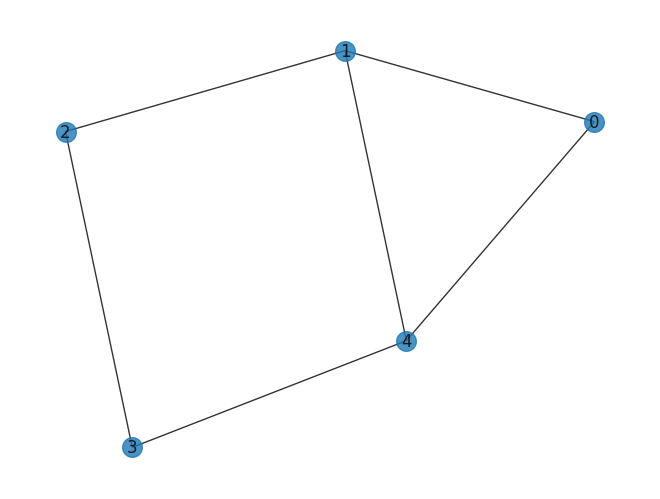

In [18]:
'''
Grafo
'''

num_vertices = 5
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0,1,0,0,1],
   [1,0,1,0,1],
   [0,1,0,1,0],
   [0,0,1,0,1],
    [1,1,0,1,0]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [21]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 5
Partição de corte máxima: [[1, 3], [0, 2, 4]]


In [ ]:
'''
Métodos para execução da estratégia QAOA
'''

# Serviço
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="7zAryvcpz2cTOgAbliiOL_A4qMyxg5Vq3nuHiBs1VENt",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/8e99d0dd96d44fd08e92d06df59c1d0a:8c991a39-9205-4233-9c72-dda37b057ae6::"
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [ ]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
estimator = Estimator()
corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**12, method="COBYLA")
parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [0.147766282659124, 5.2172115846249945, 2.7733446925422007, 1.8491876342727505, 5.3482239109887555, 1.1082538199232663, 3.096410475795309, 4.482882160064489]
Parâmetros finais: [0.14716748 5.75884762 3.01860507 2.2353252  5.22514059 0.91000866
 3.08670041 3.74187329]
Corte: 4.647103320997832
Tempo de execução: 2.0425822933514914 minutos


In [ ]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,n)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 01011
Corte Máximo: 4. Partição de corte máximo: ([1, 3, 4], [0, 2])


### Exemplo 2: Grafo com subgrafos de 5 vértices

Dimensão do grafo: 10
Matriz de pesos:


[[0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0]]

Grafo:


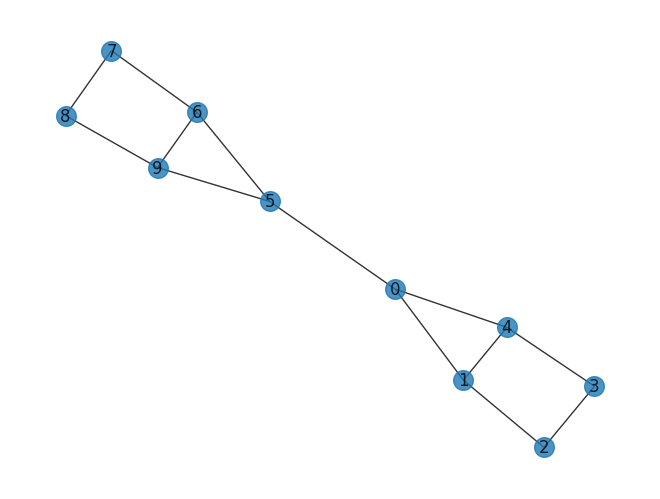

In [22]:
'''
Grafo
'''

num_vertices = 10
print(f"Dimensão do grafo: {num_vertices}")

pesos = [
   [0,1,0,0,1,1,0,0,0,0],
   [1,0,1,0,1,0,0,0,0,0],
   [0,1,0,1,0,0,0,0,0,0],
   [0,0,1,0,1,0,0,0,0,0],
   [1,1,0,1,0,0,0,0,0,0],
   [1,0,0,0,0,0,1,0,0,1],
   [0,0,0,0,0,1,0,1,0,1],
   [0,0,0,0,0,0,1,0,1,0],
   [0,0,0,0,0,0,0,1,0,1],
    [0,0,0,0,0,1,1,0,1,0]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [23]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 11
Partição de corte máxima: [[0, 1, 3, 6, 8], [2, 4, 5, 7, 9]]


In [24]:
'''
Métodos para execução da estratégia QAOA
'''

# Serviço
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="7zAryvcpz2cTOgAbliiOL_A4qMyxg5Vq3nuHiBs1VENt",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/8e99d0dd96d44fd08e92d06df59c1d0a:8c991a39-9205-4233-9c72-dda37b057ae6::"
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [31]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
estimator = Estimator()
corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYLA")
parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [3.1046083477930395, 2.087332249758763, 4.252231271880097, 0.2973792736646088, 3.6784642391514977, 0.8197338337087354, 0.9305963455903764, 5.539711407403096]
Parâmetros finais: [3.20929464 2.69948654 5.27036984 0.20182038 4.4470988  0.9413942
 1.96931798 4.95579965]
Corte: 10.307021638251289
Tempo de execução: 5.7879005670547485 minutos


In [33]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 0101001011
Corte Máximo: 9. Partição de corte máximo: ([1, 3, 6, 8, 9], [0, 2, 4, 5, 7])


### Exemplo 3: Grafo com 12 vértices

Dimensão do grafo: 12
Matriz de pesos:


[[0, 5, -2, 3, 1, -4, 2, -1, 6, 4, -3, 0],
 [5, 0, 4, -1, 2, 3, -2, 1, -5, 0, 2, -1],
 [-2, 4, 0, 2, -3, 1, 5, 0, 3, -2, 1, 4],
 [3, -1, 2, 0, 4, 1, -2, 5, 0, 2, 3, -1],
 [1, 2, -3, 4, 0, -2, 1, 3, -1, 5, 0, 2],
 [-4, 3, 1, 1, -2, 0, 4, -3, 2, 1, 5, -2],
 [2, -2, 5, -2, 1, 4, 0, 3, 2, 1, -4, 3],
 [-1, 1, 0, 5, 3, -3, 3, 0, 1, 2, 4, -2],
 [6, -5, 3, 0, -1, 2, 2, 1, 0, 4, -3, 1],
 [4, 0, -2, 2, 5, 1, 1, 2, 4, 0, 3, -2],
 [-3, 2, 1, 3, 0, 5, -4, 4, -3, 3, 0, 1],
 [0, -1, 4, -1, 2, -2, 3, -2, 1, -2, 1, 0]]

Grafo:


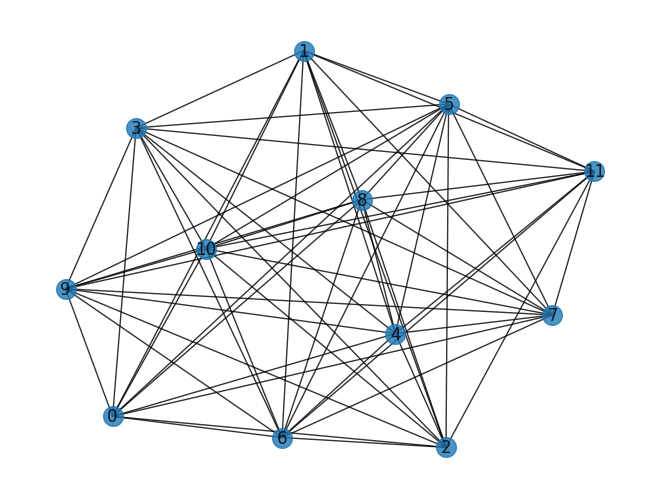

In [39]:
'''
Grafo
'''

num_vertices = 12
print(f"Dimensão do grafo: {num_vertices}")


pesos = [
    [ 0,  5, -2,  3,  1, -4,  2, -1,  6,  4, -3,  0],
    [ 5,  0,  4, -1,  2,  3, -2,  1, -5,  0,  2, -1],
    [-2,  4,  0,  2, -3,  1,  5,  0,  3, -2,  1,  4],
    [ 3, -1,  2,  0,  4,  1, -2,  5,  0,  2,  3, -1],
    [ 1,  2, -3,  4,  0, -2,  1,  3, -1,  5,  0,  2],
    [-4,  3,  1,  1, -2,  0,  4, -3,  2,  1,  5, -2],
    [ 2, -2,  5, -2,  1,  4,  0,  3,  2,  1, -4,  3],
    [-1,  1,  0,  5,  3, -3,  3,  0,  1,  2,  4, -2],
    [ 6, -5,  3,  0, -1,  2,  2,  1,  0,  4, -3,  1],
    [ 4,  0, -2,  2,  5,  1,  1,  2,  4,  0,  3, -2],
    [-3,  2,  1,  3,  0,  5, -4,  4, -3,  3,  0,  1],
    [ 0, -1,  4, -1,  2, -2,  3, -2,  1, -2,  1,  0]
]

print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if pesos[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [40]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 76
Partição de corte máxima: [[1, 3, 6, 8, 10], [0, 2, 4, 5, 7, 9, 11]]


In [37]:
'''
Métodos para execução da estratégia QAOA
'''

# Serviço
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="7zAryvcpz2cTOgAbliiOL_A4qMyxg5Vq3nuHiBs1VENt",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/8e99d0dd96d44fd08e92d06df59c1d0a:8c991a39-9205-4233-9c72-dda37b057ae6::"
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [41]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 4
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
parametros = parametros_iniciais
estimator = Estimator()
corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**12, method="COBYLA")
parametros_max = corte.x
corte_max = - corte.fun #Troca de sinal
print(f"Parâmetros finais: {parametros_max}")
print(f"Corte: {corte_max}")

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 4 (tipo: <class 'int'>
Parâmetros iniciais: [2.7835416766399477, 2.3716035914886113, 1.2265194976295388, 5.920106452679008, 1.1887947732955428, 3.03484908896112, 6.033909458554728, 2.537477251082261]
Parâmetros finais: [2.11021198 2.07772288 0.75491586 5.43360964 1.46549508 2.85162161
 5.98042065 2.39563584]
Corte: 34.02959694068283
Tempo de execução: 12.907600994904836 minutos


In [43]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_vertices)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 001011100100
Corte Máximo: 40. Partição de corte máximo: ([2, 4, 5, 6, 9], [0, 1, 3, 7, 8, 10, 11])


### Exemplo XXX: Grafo com 14 vértices e pesos variáveis

Dimensão do grafo: 14
Matriz de pesos:


[[0.0, 0.36, 0.47, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.36, 0.0, 0.0, 0.0, 0.16, 0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.47, 0.0, 0.0, 0.37, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.14, 0.0, 0.37, 0.0, 0.0, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.16, 0.0, 0.0, 0.0],
 [0.0, 0.69, 0.0, 0.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.19, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.66, 0.0, 0.0, 0.0, 0.52],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, 0.66, 0.0, 0.0, 0.43, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76, 0.15],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.76, 0.0, 0.43, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19, 0.0, 0.0, 0.76, 0.0, 0.0, 0.38],
 [0.0, 0.0, 0.0,

Grafo:


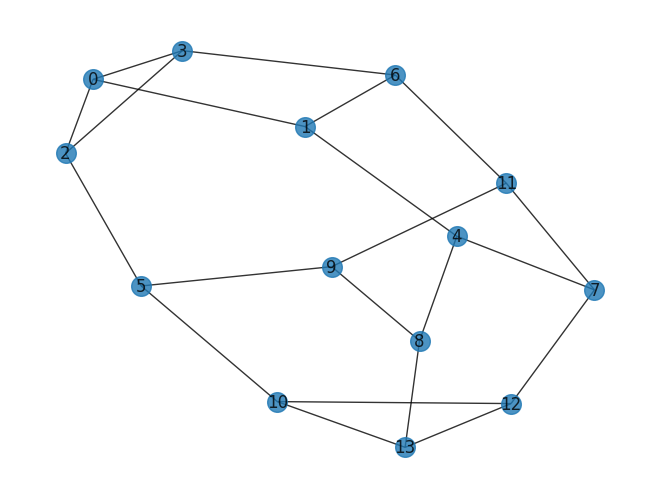

In [ ]:
'''
Grafo
'''

num_vertices = 14
print(f"Dimensão do grafo: {n}")

pesos = [
   [0.00,0.36,0.47,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.36,0.00,0.00,0.00,0.16,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.47,0.00,0.00,0.37,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.14,0.00,0.37,0.00,0.00,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.82,0.70,0.00,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.90,0.16,0.00,0.00,0.00],
   [0.00,0.69,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.19,0.00],
   [0.00,0.00,0.00,0.00,0.70,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.52],
   [0.00,0.00,0.00,0.00,0.00,0.90,0.00,0.00,0.66,0.00,0.00,0.43,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.15],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.76,0.00,0.43,0.00,0.00,0.00,0.00],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.76,0.00,0.00,0.38],
   [0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.15,0.00,0.38,0.00]
]
print("Matriz de pesos:")
display(pesos)

# Impressão do grafo
import networkx as nx

G = nx.Graph()
vertices = range(num_vertices)
G.add_nodes_from(vertices)

arestas = []
for i in range(num_vertices):
    for j in range(num_vertices):
        if w[i][j] != 0:
            arestas.append((i,j))
G.add_edges_from(arestas)

print("Grafo:")
nx.draw(G, with_labels=True, alpha=0.8, node_size=200)

In [ ]:
'''
Resolução clássica
'''

corte_maximo = MaxCut(num_vertices, pesos)

print(f"Corte máximo: {corte_maximo[0]}")
print(f"Partição de corte máxima: {corte_maximo[1]}")

Corte máximo: 9.53
Partição de corte máxima: [[0, 5, 6, 7, 8, 12], [1, 2, 3, 4, 9, 10, 11, 13]]


In [ ]:
'''
Métodos para implementar estratégia QAOA
'''

# Serviço
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel="ibm_cloud",
    token="7zAryvcpz2cTOgAbliiOL_A4qMyxg5Vq3nuHiBs1VENt",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/8e99d0dd96d44fd08e92d06df59c1d0a:8c991a39-9205-4233-9c72-dda37b057ae6::"
    )

## Backend fake
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane() # FakeBrisbane(): 127 qubits. Mais fake backends: 'https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/fake-provider'

# Initialize Estimator
from qiskit_aer.primitives import EstimatorV2
Estimator = EstimatorV2

# Transpilador
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

In [ ]:
'''
Estratégia QAOA
'''
import time
inicio = time.time()

# Profundidade
p = 5
print(f"Profundidade: {p} (tipo: {type(p)}")

# Parâmetros iniciais
parametros_iniciais = [2*np.pi*np.random.random() for k in range(2*p)]
print(f"Parâmetros iniciais: {parametros_iniciais}")

# Negativo de CorteQ
def neg_CorteQ(parametros, num_vertices, pesos, p, estimator):
    valor = CorteQ(parametros, num_vertices, pesos, p, estimator)
    return -valor

# Maximização de CorteQ (pela minimização de -CorteQ = neg_CorteQ)
num_iteracoes = 2
for k in range(num_iteracoes):
    parametros = parametros_iniciais
    estimator = Estimator()
    corte = minimize(neg_CorteQ, parametros, args = (num_vertices, pesos, p, estimator), tol = 1/2**15, method="COBYLA")
    parametros = corte.x
    corte_max = - corte.fun #Troca de sinal
    print(f"Iteração: {k+1}")
    print(f"Parâmetros finais: {parametros}")
    print(f"Corte: {corte_max}")
parametros_max = parametros

fim = time.time()
print(f"Tempo de execução: {(fim - inicio)/60} minutos")

Profundidade: 5 (tipo: <class 'int'>
Parâmetros iniciais: [2.064605103428956, 0.5304349422515429, 3.355498643453823, 3.42407697045392, 1.658720384021261, 0.9623496531023915, 3.984787290975719, 5.108133254688142, 0.26337480635782834, 3.8008505696032255]
Iteração: 1
Parâmetros finais: [ 4.04624483 -0.06462892  4.90504168  3.98014197  1.5146582   0.3731313
  4.28732091  5.41510178  0.37164969  3.59892163]
Corte: 6.346780918544418
Iteração: 2
Parâmetros finais: [ 4.04320557 -0.05429071  4.90618003  3.95940876  1.52137817  0.37420969
  4.28778147  5.41309948  0.36730791  3.602923  ]
Corte: 6.346687701358701
Tempo de execução: 38.22970992724101 minutos


In [ ]:
'''
Pós-processamento
'''

gama_vec = list(parametros_max[:p])
beta_vec = list(parametros_max[p:])

circ = QAOA_Ansatz(num_vertices, pesos, p, gama_vec, beta_vec)

# Estado de corte máximo
estado_maxcut = estado_base_max(circ,num_pesos)
print(f"Estado-base de corte máximo: {estado_maxcut}")

# Partição de corte máximo
A = []; B = []
for k in range(num_vertices):
    if estado_maxcut[k] == '1':
        A.append(k)
    else:
        B.append(k)
print(f"Corte Máximo: {Corte(pesos, A)}. Partição de corte máximo: {(A,B)}")

Estado-base de corte máximo: 01000011101001
Corte Máximo: 6.6. Partição de corte máximo: ([1, 6, 7, 8, 10, 13], [0, 2, 3, 4, 5, 9, 11, 12])
